# Analyzing Distributed Data with Spark

## Initialisierung der Spark Application

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql import dataframe
from pyspark.sql.functions import to_timestamp, to_date, year, dayofweek
from scipy import stats

In [2]:
# Spark session & context
spark = SparkSession \
    .builder \
    .master('spark://spark-master:7077') \
    .appName("uebung_26") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

In [3]:
# Create connection to csv file and inspect it
def read_and_format_csv(path, sep=',', header=True, date_col=None):
    # Read in the dataframe
    df = spark.read.csv(
        path=path, 
        sep=sep,
        header=header,
        inferSchema=True)
    
    # Make sure dates are in date format (and not strings)
    if date_col is not None:
        df = df.withColumn(date_col, to_date(date_col, 'yyyy-MM-dd'))
    
    # Printing some info
    print(f'Number of rows: {df.count()}')
    print(df.printSchema())
    print(df.show(5))
    return df

## Einlesen aller relevanten Dateien

In [4]:
holidays = read_and_format_csv(
    'hdfs://namenode:8020/user/root/workspace/pyspark/holidays_events.csv', 
    date_col='datum_holi')

Number of rows: 350
root
 |-- datum_holi: date (nullable = true)
 |-- type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: boolean (nullable = true)

None
+----------+-------+--------+-----------+--------------------+-----------+
|datum_holi|   type|  locale|locale_name|         description|transferred|
+----------+-------+--------+-----------+--------------------+-----------+
|2012-03-02|Holiday|   Local|      Manta|  Fundacion de Manta|      false|
|2012-04-01|Holiday|Regional|   Cotopaxi|Provincializacion...|      false|
|2012-04-12|Holiday|   Local|     Cuenca| Fundacion de Cuenca|      false|
|2012-04-14|Holiday|   Local|   Libertad|Cantonizacion de ...|      false|
|2012-04-21|Holiday|   Local|   Riobamba|Cantonizacion de ...|      false|
+----------+-------+--------+-----------+--------------------+-----------+
only showing top 5 rows

None


In [5]:
items = read_and_format_csv('hdfs://namenode:8020/user/root/workspace/pyspark/items.csv')

Number of rows: 4100
root
 |-- item_nbr_item: integer (nullable = true)
 |-- family: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)

None
+-------------+------------+-----+----------+
|item_nbr_item|      family|class|perishable|
+-------------+------------+-----+----------+
|        96995|   GROCERY I| 1093|         0|
|        99197|   GROCERY I| 1067|         0|
|       103501|    CLEANING| 3008|         0|
|       103520|   GROCERY I| 1028|         0|
|       103665|BREAD/BAKERY| 2712|         1|
+-------------+------------+-----+----------+
only showing top 5 rows

None


In [6]:
stores = read_and_format_csv(
    'hdfs://namenode:8020/user/root/workspace/pyspark/quito_stores_sample2016-2017.csv',
    date_col='date_quito')

Number of rows: 1222017
root
 |-- id: integer (nullable = true)
 |-- date_quito: date (nullable = true)
 |-- store_nbr_quito: integer (nullable = true)
 |-- item_nbr_quito: integer (nullable = true)
 |-- unit_sales: double (nullable = true)
 |-- onpromotion: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- cluster: integer (nullable = true)

None
+--------+----------+---------------+--------------+----------+-----------+-----+---------+-------+
|      id|date_quito|store_nbr_quito|item_nbr_quito|unit_sales|onpromotion| city|    state|cluster|
+--------+----------+---------------+--------------+----------+-----------+-----+---------+-------+
|88211471|2016-08-16|             44|        103520|       7.0|       true|Quito|Pichincha|      5|
|88211472|2016-08-16|             44|        103665|       7.0|      false|Quito|Pichincha|      5|
|88211473|2016-08-16|             44|        105574|      13.0|      false|Quito|Pichincha|     

In [7]:
transactions = read_and_format_csv(
    'hdfs://namenode:8020/user/root/workspace/pyspark/transactions.csv',
    date_col='date_trans')

Number of rows: 83488
root
 |-- date_trans: date (nullable = true)
 |-- store_nbr_trans: integer (nullable = true)
 |-- transactions: integer (nullable = true)

None
+----------+---------------+------------+
|date_trans|store_nbr_trans|transactions|
+----------+---------------+------------+
|2013-01-01|             25|         770|
|2013-01-02|              1|        2111|
|2013-01-02|              2|        2358|
|2013-01-02|              3|        3487|
|2013-01-02|              4|        1922|
+----------+---------------+------------+
only showing top 5 rows

None


## Teilaufgabe 1
Summe der `unit_sales` für das Jahr 2017 pro `item_nbr` ==> Summe der `unit_sales` vom Jahr 2017 gruppiert nach `item_nbr_quito`

In [8]:
# Extract the year from date_quito
stores = stores.withColumn('year', year('date_quito'))

In [9]:
# Get a subset of year 2017, group it by item_nbr_quito and calculate the sum
item_unit_sales = stores.filter(stores['year'] == 2017)
item_unit_sales.show(10)

+---+----------+---------------+--------------+----------+-----------+----+-----+-------+----+
| id|date_quito|store_nbr_quito|item_nbr_quito|unit_sales|onpromotion|city|state|cluster|year|
+---+----------+---------------+--------------+----------+-----------+----+-----+-------+----+
+---+----------+---------------+--------------+----------+-----------+----+-----+-------+----+



Da es anscheinend keine Einträge für das Jahr 2017 gibt, werde ich stattdessen das Jahr 2016 benutzen.

In [10]:
item_unit_sales = stores.filter(stores['year'] == 2016)
item_unit_sales = item_unit_sales.groupBy('item_nbr_quito').sum('unit_sales').orderBy('sum(unit_sales)')
item_unit_sales.show(10)

+--------------+---------------+
|item_nbr_quito|sum(unit_sales)|
+--------------+---------------+
|        584129|          0.974|
|       1994926|            1.0|
|       1094238|            1.0|
|        906980|            1.0|
|       1937611|            1.0|
|       1123722|            1.0|
|       2026312|            1.0|
|        907686|            1.0|
|       1963892|            1.0|
|        856687|            1.0|
+--------------+---------------+
only showing top 10 rows



## Teilaufgabe 2
Anzahl Verkaufsposition pro family ==> Berechnen der Anzahl an `items` pro Familie

In [11]:
items_per_family = items.groupBy('family').count().orderBy('count', ascending=False)
items_per_family.show(10)

+-------------+-----+
|       family|count|
+-------------+-----+
|    GROCERY I| 1334|
|    BEVERAGES|  613|
|     CLEANING|  446|
|      PRODUCE|  306|
|        DAIRY|  242|
|PERSONAL CARE|  153|
| BREAD/BAKERY|  134|
|    HOME CARE|  108|
|         DELI|   91|
|        MEATS|   84|
+-------------+-----+
only showing top 10 rows



## Exercise 3
`store_nbr` mit den meisten `unit_sales` ==> Berechnung der `store_nbr_quito` mit den meisten `unit_sales`

In [12]:
best_store = stores.groupBy('store_nbr_quito') \
    .sum('unit_sales') \
    .orderBy('sum(unit_sales)', ascending=False) \
    .limit(1)
best_store.show()

+---------------+-----------------+
|store_nbr_quito|  sum(unit_sales)|
+---------------+-----------------+
|             44|3433300.865999999|
+---------------+-----------------+



## Teilaufgabe 4
Gibt es ein Muster in den täglichen `unit_sales`? 

1. Um allgemeine Veränderungen in `unit_sales` zu sehen, werde ich einen Line Plot von allen täglichen `unit_sales` über die gesamte Zeitspanne machen.

2. Um herauszufinden ob es eine Korrelation zwischen täglichen `unit_sales` und Wochentagen gibt, werde ich einen Boxplot von täglichen `unit_sales` gruppiert nach Wochentagen erstellen

3. Um herauszufinden, ob es eine Korrelation zwischen täglichen `unit_sales` und Feiertagen gibt, werde ich einen Boxplot von `unit_sales` gruppiert nach Feiertagen erstellen

Bei obigen Berechnungen werde ich versuchen möglichst viele Berechnungen im Spark Cluster ausführen zu lassen und Resilient Distributed Datasets (RDDs) möglichst spät in pandas DataFrames zu konvertieren. Denn sobald ein RDD in einen pandas DataFrame konvertiert wurde, befindet sich der gesamte Datensatz auf dem Treiber, also auf diesem Juypter Notebook Server, was zu erheblichen Performance Einbüßen führen könnte.

   date_quito  sum(unit_sales)
0  2016-08-16       168369.373
1  2016-08-17       182923.647
2  2016-08-18       138728.353
3  2016-08-19       181135.568
4  2016-08-20       224070.580


<AxesSubplot:xlabel='date_quito'>

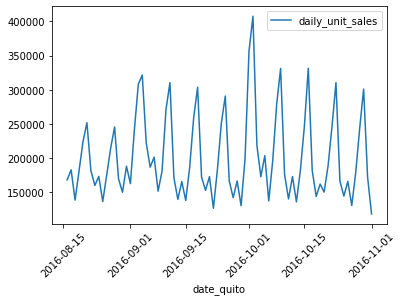

In [13]:
# 1. Plot all daily unit sales
daily = stores.groupBy('date_quito') \
    .sum('unit_sales') \
    .orderBy('date_quito', ascending=True) \
    .toPandas()
print(daily.head())
daily.rename(columns={'sum(unit_sales)': 'daily_unit_sales'}, inplace=True)
daily.plot(x='date_quito', y='daily_unit_sales', rot=45)

Auffälligkeiten: 
Binnen jedes Monats gibt es 4-5 lokale Minima/Maxima ==> Vielleicht wird an Wochenenden mehr/weniger verkauft als unter der Woche. Ob dies stimmt, werden wir in folgenden Boxplots sehen

  date_quito  daily_unit_sales day_of_week
0 2016-08-16        168369.373     Tuesday
1 2016-08-17        182923.647   Wednesday
2 2016-08-18        138728.353    Thursday
3 2016-08-19        181135.568      Friday
4 2016-08-20        224070.580    Saturday


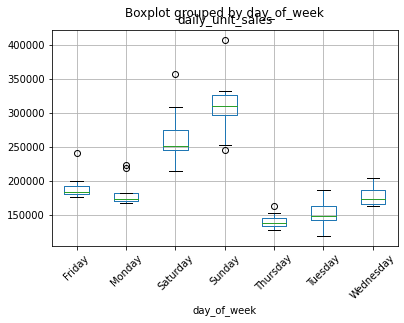

In [14]:
# 2. Boxplot of unit sales grouped by day of week
daily['date_quito'] = pd.to_datetime(daily['date_quito'])
daily['day_of_week'] = daily['date_quito'].dt.day_name()
print(daily.head())
_ = daily.boxplot('daily_unit_sales', by='day_of_week', rot=45)

Hier sieht man auf einmal ganz klar, dass an Wochenenden sehr viel mehr als unter der Woche verkauft wird.

Number of common dates: 4


<AxesSubplot:title={'center':'sum(unit_sales)'}, xlabel='type'>

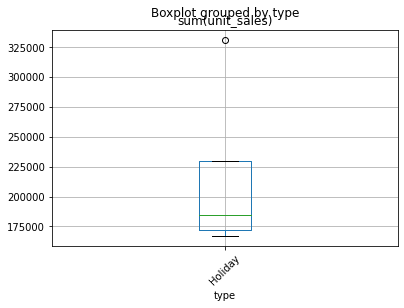

In [15]:
# 3. Boxplot of daily_unit_sales grouped by holiday
daily_unit_sales = stores.groupBy('date_quito').sum('unit_sales')
sales_and_holidays = daily_unit_sales.join(
    holidays, 
    daily_unit_sales['date_quito'] == holidays['datum_holi'], 
    'inner'
)
print(f'Number of common dates: {sales_and_holidays.count()}')
sales_and_holidays.toPandas().boxplot('sum(unit_sales)', by='type', rot=45)

Es gibt leider nur 4 Daten, die `daily_unit_sales` und `holidays` gemeinsam haben, und leider sind von diesen 4 Daten alle ein Holiday, also kann man mit dem obigen Boxplot leider nicht die Frage beantworten, ob es eine Korrelation zwischen täglichen `unit_sales` und den `type` von `holidays` gibt.

Um zu überprüfen, ob es tatsächlich nur 4 gemeinsame Daten gibt, werde ich die gleiche JOIN Operation zwischen `daily_unit_sales` und `holidays` mit nochmals mit pandas durchführen

In [16]:
# Joing daily_unit_sales and holidays as pandas DataFrames
daily_unit_sales_df = daily_unit_sales.toPandas()
daily_unit_sales_df = daily.rename(columns={'sum(unit_sales)': 'daily_unit_sales'})
daily_unit_sales_df['date_quito'] = pd.to_datetime(daily_unit_sales_df['date_quito'])
holidays_df = holidays.toPandas()
holidays_df['datum_holi'] = pd.to_datetime(holidays_df['datum_holi'])
d_and_h = daily_unit_sales_df.merge(holidays_df, left_on='date_quito', right_on='datum_holi', how='inner')
len(d_and_h)

4

In [17]:
# NEVER FORGET to stop the session
spark.stop()